# Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import pickle as pkl

# Load data

In [2]:
df_train = pd.read_csv('data/ready/novelty_detection/train.csv')
df_train.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [3]:
df_test = pd.read_csv('data/ready/novelty_detection/test.csv')
df_test.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,11629.0,-3.891192,7.098916,-11.426467,8.607557,-2.065706,-2.985288,-8.138589,2.973928,-6.272790,...,1.757085,-0.189709,-0.508629,-1.189308,1.188536,0.605242,1.881529,0.875260,1.0,1
1,11635.0,0.919137,4.199633,-7.535607,7.426940,1.118215,-2.886722,-1.341036,0.363933,-2.203224,...,0.316094,0.055179,0.210692,-0.417918,-0.911188,0.466524,0.627393,0.157851,1.0,1
2,12093.0,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,...,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,0.0,1


# Prepare data

In [4]:
with open('data/models/novelty_detection/scaler_stats.pkl', 'rb') as handle:
    stats = pkl.load(handle)
    
stats

{'V9': {'mean': 0.7146190771795187, 'std': 1.1408180520740157},
 'V5': {'mean': -0.034014064445657896, 'std': 1.1469934107507669},
 'V25': {'mean': 0.08816896455896987, 'std': 0.422913932767026},
 'V28': {'mean': 0.0012378722056445982, 'std': 0.27084898091255255},
 'V23': {'mean': -0.03642609648668205, 'std': 0.47721176144869615},
 'V15': {'mean': -0.0832484387421991, 'std': 0.9762988869944756},
 'V27': {'mean': 0.009360769856715148, 'std': 0.3969568709147506},
 'V1': {'mean': -0.2603650842925114, 'std': 1.491390025700216},
 'V19': {'mean': -0.05525353643229752, 'std': 0.8024721730721641},
 'V14': {'mean': 0.6405087677843762, 'std': 1.0283090565656978},
 'V7': {'mean': -0.03326239531396446, 'std': 1.0283209938929365},
 'V3': {'mean': 0.9237004737020951, 'std': 1.0265360949372908},
 'V22': {'mean': -0.1568740594384358, 'std': 0.6455801984878736},
 'V10': {'mean': -0.1649298758068517, 'std': 1.025247290830579},
 'V26': {'mean': 0.06246142347345862, 'std': 0.5429930869740929},
 'V17': {'m

In [5]:
for col in stats.keys():
    df_train[col] = (df_train[col] - stats[col]['mean']) / stats[col]['std']
    df_test[col] = (df_test[col] - stats[col]['mean']) / stats[col]['std']

In [6]:
cols_x = stats.keys()

# Model

In [7]:
input_ = tf.keras.layers.Input(shape=(29,))

# Encoder layers
encoder = tf.keras.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(4, activation='relu')])(input_)

# Decoder layers
decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(29, activation="sigmoid")])(encoder)

# Create the autoencoder
autoencoder = tf.keras.Model(inputs=input_, outputs=decoder)

2023-06-11 12:45:22.647011: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train

In [8]:
autoencoder.compile(optimizer='adam', loss='mae')

# Fit the autoencoder
history = autoencoder.fit(df_train[cols_x], df_train[cols_x], 
          epochs=20, 
          batch_size=64,
          #validation_data=(X_test, X_test),
          shuffle=True)

Epoch 1/20
134/134 [==============================] - 0s 645us/step - loss: 0.7505
Epoch 2/20
134/134 [==============================] - 0s 577us/step - loss: 0.6734
Epoch 3/20
134/134 [==============================] - 0s 589us/step - loss: 0.6601
Epoch 4/20
134/134 [==============================] - 0s 587us/step - loss: 0.6470
Epoch 5/20
134/134 [==============================] - 0s 594us/step - loss: 0.6416
Epoch 6/20
134/134 [==============================] - 0s 605us/step - loss: 0.6369
Epoch 7/20
134/134 [==============================] - 0s 597us/step - loss: 0.6326
Epoch 8/20
134/134 [==============================] - 0s 578us/step - loss: 0.6292
Epoch 9/20
134/134 [==============================] - 0s 578us/step - loss: 0.6270
Epoch 10/20
134/134 [==============================] - 0s 571us/step - loss: 0.6247
Epoch 11/20
134/134 [==============================] - 0s 572us/step - loss: 0.6223
Epoch 12/20
134/134 [==============================] - 0s 586us/step - loss: 0.6204
E

The prediction loss threshold for 2% of outliers is 6.14


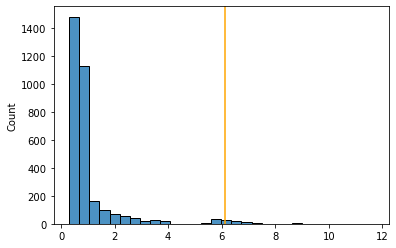

In [11]:
prediction = autoencoder.predict(df_test[cols_x])

# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, df_test[cols_x])

# Check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')

In [13]:
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]

# # Check the prediction performance
print(classification_report(df_test['Class'], threshold_prediction))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2758
           1       0.97      0.14      0.24       464

    accuracy                           0.87      3222
   macro avg       0.92      0.57      0.59      3222
weighted avg       0.89      0.87      0.83      3222



TEST accuracy = 0.8749224084419616
TEST recall = 0.9692307692307692


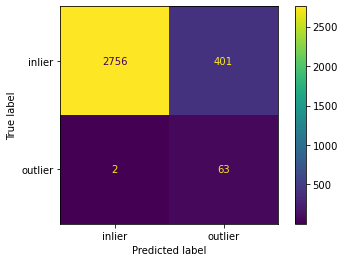

In [15]:
acc = accuracy_score(threshold_prediction, df_test['Class'])
rec = recall_score(threshold_prediction, df_test['Class'])

cm = confusion_matrix(threshold_prediction, df_test['Class'])

print(f'TEST accuracy = {acc}')
print(f'TEST recall = {rec}')

cm_plot = ConfusionMatrixDisplay(cm, display_labels=['inlier', 'outlier'])

cm_plot.plot()